Using device: cuda


Epoch 1/20 [Validation]: 100%|██████████| 59/59 [00:55<00:00,  1.07it/s, acc=72.4, loss=1.74]



Epoch 1 completed in 10.18m, Total time: 10.18m, lr: 0.00050


Epoch 2/20 [Validation]: 100%|██████████| 59/59 [00:52<00:00,  1.12it/s, acc=75.9, loss=1.6] 



Epoch 2 completed in 10.44m, Total time: 20.62m, lr: 0.00049


Epoch 3/20 [Validation]: 100%|██████████| 59/59 [00:51<00:00,  1.14it/s, acc=76.5, loss=1.58]



Epoch 3 completed in 10.15m, Total time: 30.77m, lr: 0.00047


Epoch 4/20 [Validation]: 100%|██████████| 59/59 [00:52<00:00,  1.13it/s, acc=77, loss=1.58]  



Epoch 4 completed in 10.11m, Total time: 40.88m, lr: 0.00045


Epoch 5/20 [Validation]: 100%|██████████| 59/59 [00:51<00:00,  1.15it/s, acc=75.7, loss=1.61]



Epoch 5 completed in 10.26m, Total time: 51.14m, lr: 0.00043
⏳ Early stopping patience: 1/3


Epoch 6/20 [Validation]: 100%|██████████| 59/59 [00:52<00:00,  1.13it/s, acc=76.5, loss=1.6] 



Epoch 6 completed in 10.17m, Total time: 61.31m, lr: 0.00040
⏳ Early stopping patience: 2/3


Epoch 7/20 [Validation]: 100%|██████████| 59/59 [00:52<00:00,  1.12it/s, acc=76, loss=1.59]  



Epoch 7 completed in 10.09m, Total time: 71.40m, lr: 0.00036
⏳ Early stopping patience: 3/3

⏹️ Early stopping triggered at epoch 7

✅ Training completed!

✅ Model saved to: /kaggle/working/food101_model.pth


Testing: 100%|██████████| 198/198 [02:53<00:00,  1.14it/s]



Classification Report:

                         precision    recall  f1-score   support

                churros       0.87      0.92      0.89       250
      hot_and_sour_soup       0.92      0.91      0.92       250
                 samosa       0.83      0.82      0.82       250
                sashimi       0.96      0.84      0.90       250
              pork_chop       0.64      0.53      0.58       250
           spring_rolls       0.89      0.81      0.85       250
            panna_cotta       0.70      0.81      0.75       250
           beef_tartare       0.76      0.84      0.80       250
            greek_salad       0.81      0.79      0.80       250
              foie_gras       0.52      0.68      0.59       250
                  tacos       0.79      0.72      0.76       250
               pad_thai       0.91      0.89      0.90       250
                poutine       0.83      0.93      0.87       250
                  ramen       0.87      0.81      0.84       250

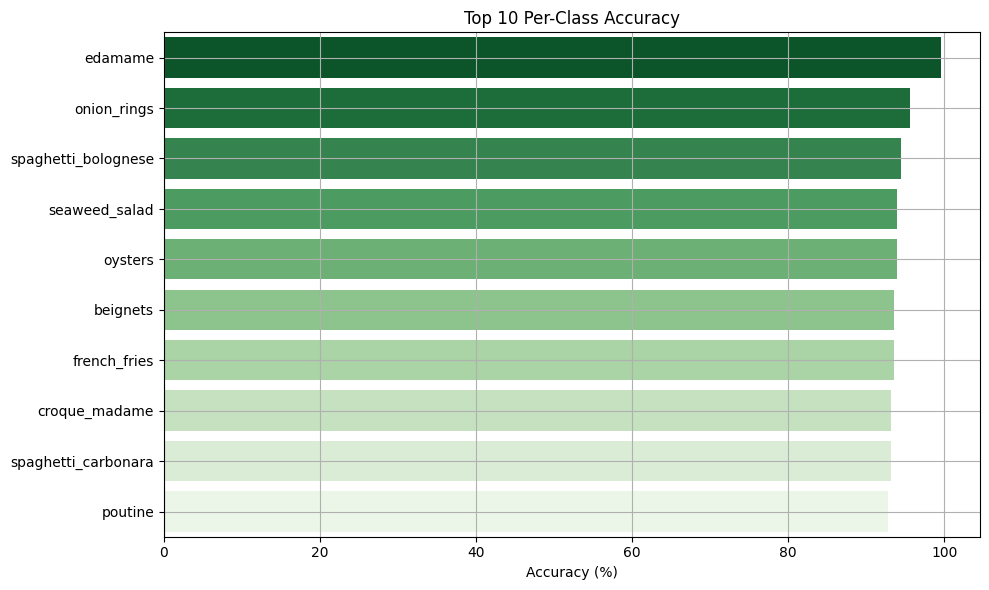

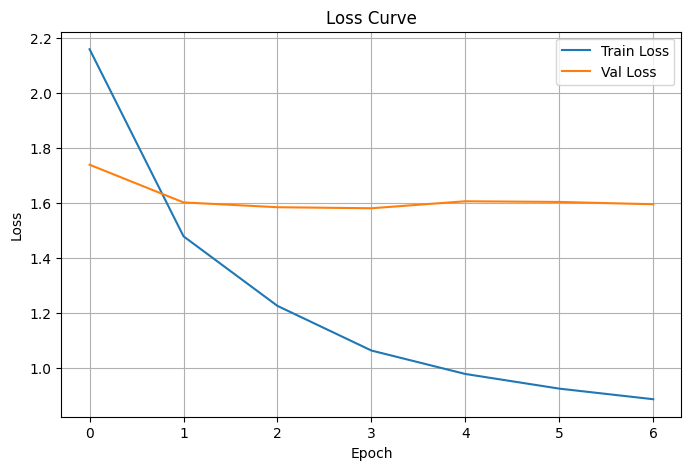

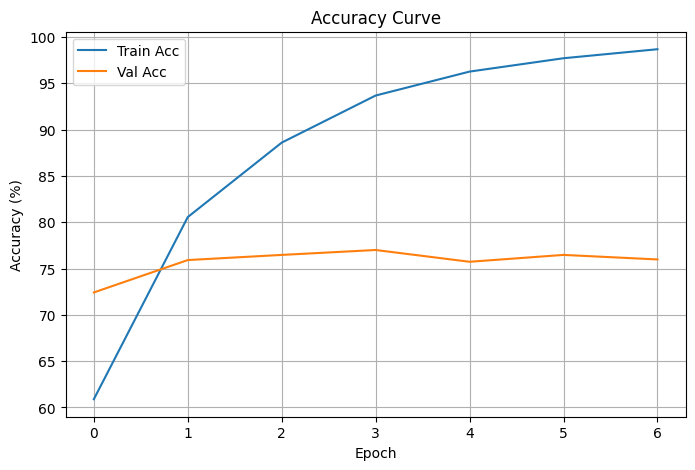

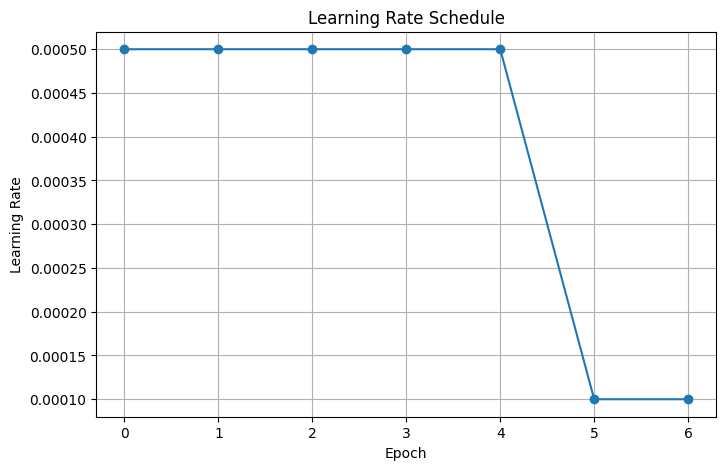

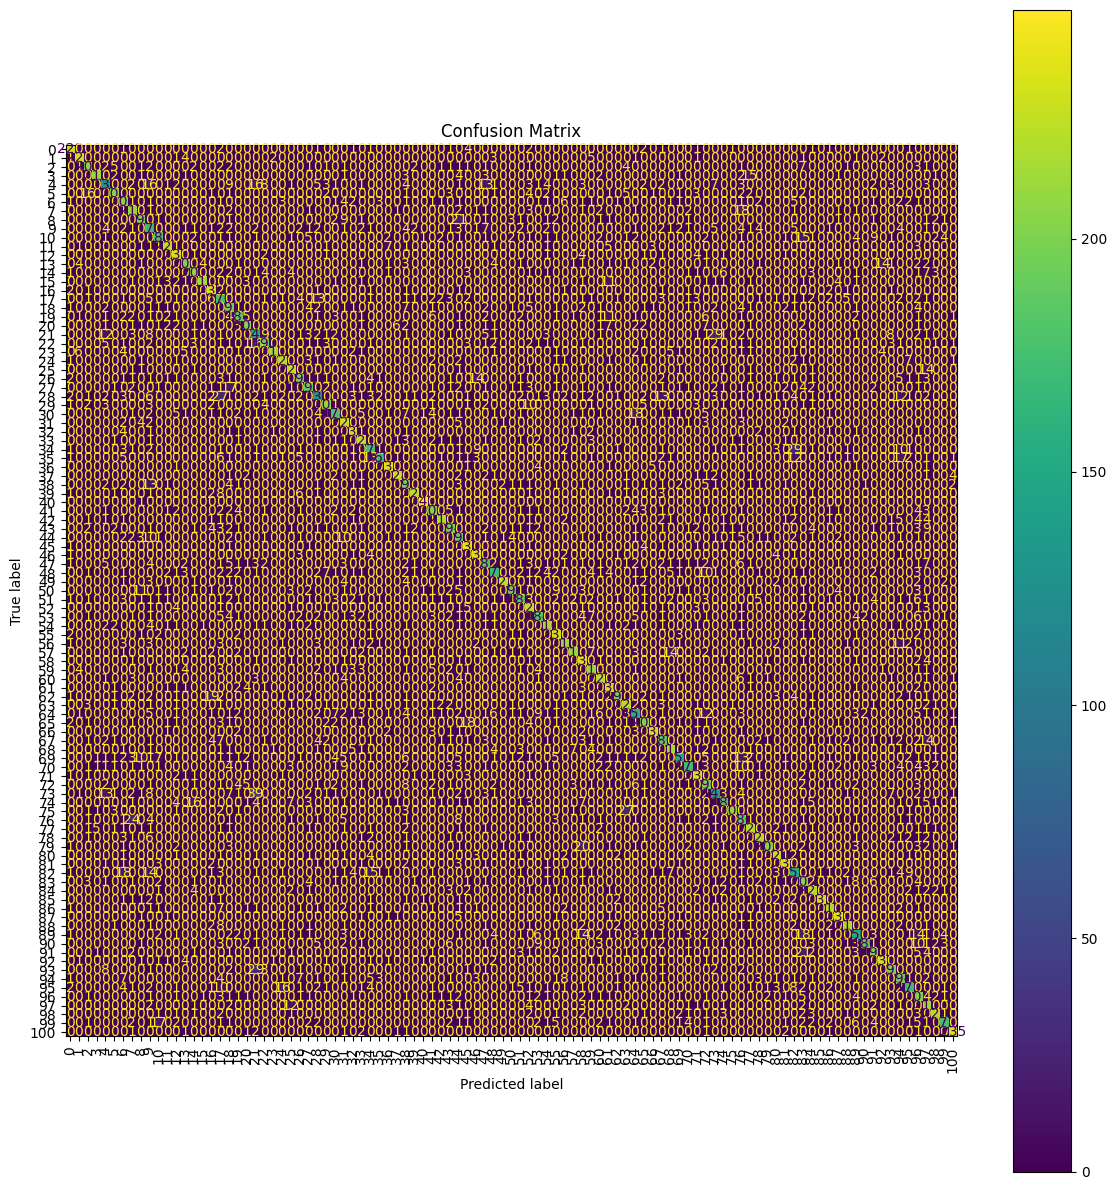

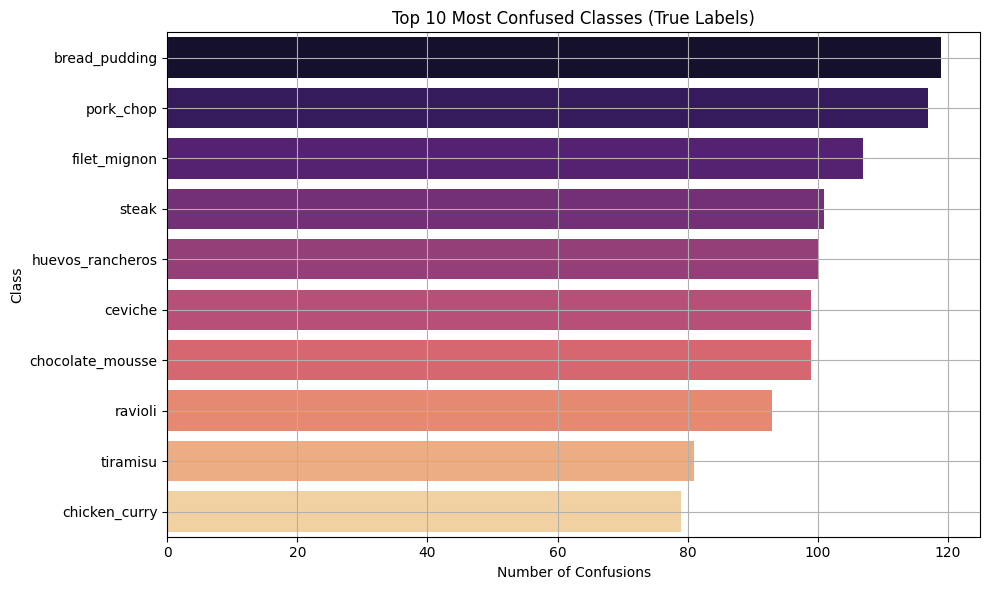

In [4]:
# ---------- IMPORTS ----------
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import InterpolationMode
from PIL import Image
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import warnings
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

# Ignore warnings
warnings.filterwarnings('ignore')

# ---------- PATH SETUP ----------
# Make sure you've added the Food-101 dataset to the notebook via "Add Data"
path = "/kaggle/input/food41"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------- CUSTOM DATASET ----------
class Food101Dataset(Dataset):
    def __init__(self, json_path, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        with open(json_path) as f:
            data = json.load(f)

        self.image_paths = []
        self.labels = []
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(data.keys())}

        for cls_name, images in data.items():
            cls_idx = self.class_to_idx[cls_name]
            for img_path in images:
                self.image_paths.append(img_path)
                self.labels.append(cls_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, 'images', f"{self.image_paths[idx]}.jpg")
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# ---------- TRANSFORMS ----------
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.08, 0.08), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ---------- DATASET & SPLITS ----------
train_json = os.path.join(path, "meta", "meta", "train.json")
test_json = os.path.join(path, "meta", "meta", "test.json")

full_train_dataset = Food101Dataset(train_json, path, train_transform)
val_size = int(0.1 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_test_transform
test_dataset = Food101Dataset(test_json, path, val_test_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# ---------- MODEL ----------
weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet = torchvision.models.resnet50(weights=weights)
resnet.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(resnet.fc.in_features, 101)
)

# Freeze all layers except layer3, layer4 and fc
for param in resnet.parameters():
    param.requires_grad = False

for name, param in resnet.named_parameters():
    if any(x in name for x in ['layer3', 'layer4', 'fc']):
        param.requires_grad = True

resnet.to(device)

# ---------- TRAINING SETUP ----------
lr = 0.0005
l2 = 1e-4
lossfun = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(resnet.parameters(), lr=lr, weight_decay=l2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# ---------- TRAINING LOOP ----------
def train_model():
    numepochs = 20  # allow for early stopping
    patience = 3
    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    valAcc = torch.zeros(numepochs)

    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_state = None

    start_time = time.time()
    for epochi in range(numepochs):
        epoch_start_time = time.time()

        resnet.train()
        batch_train_loss = []
        batch_train_acc = []
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epochi+1}/{numepochs} [Training]")

        for X, y in train_loader_tqdm:
            X, y = X.to(device), y.to(device)
            yHat = resnet(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (torch.argmax(yHat, axis=1) == y).float().mean().item()
            batch_train_loss.append(loss.item())
            batch_train_acc.append(acc)

            train_loader_tqdm.set_postfix(loss=np.mean(batch_train_loss), acc=100*np.mean(batch_train_acc))

        trainLoss[epochi] = np.mean(batch_train_loss)
        trainAcc[epochi] = 100 * np.mean(batch_train_acc)

        resnet.eval()
        batch_val_loss = []
        batch_val_acc = []
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epochi+1}/{numepochs} [Validation]")

        with torch.no_grad():
            for X, y in val_loader_tqdm:
                X, y = X.to(device), y.to(device)
                yHat = resnet(X)
                loss = lossfun(yHat, y)

                acc = (torch.argmax(yHat, axis=1) == y).float().mean().item()
                batch_val_loss.append(loss.item())
                batch_val_acc.append(acc)

                val_loader_tqdm.set_postfix(loss=np.mean(batch_val_loss), acc=100*np.mean(batch_val_acc))

        valLoss[epochi] = np.mean(batch_val_loss)
        valAcc[epochi] = 100 * np.mean(batch_val_acc)

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        epoch_time = (time.time() - epoch_start_time) / 60
        total_time = (time.time() - start_time) / 60
        print(f"\nEpoch {epochi+1} completed in {epoch_time:.2f}m, Total time: {total_time:.2f}m, lr: {current_lr:.5f}")

        # ---- Early Stopping ----
        if valLoss[epochi] < best_val_loss:
            best_val_loss = valLoss[epochi]
            best_model_state = resnet.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f" Early stopping patience: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print(f"\n Early stopping triggered at epoch {epochi+1}")
            break

    print("\n Training completed!")

    # Load best model
    if best_model_state:
        resnet.load_state_dict(best_model_state)

    # Save model
    output_dir = "/kaggle/working"
    os.makedirs(output_dir, exist_ok=True)
    model_path = os.path.join(output_dir, "food101_model.pth")

    final_model_state = {
        'model_state_dict': resnet.state_dict(),
        'class_to_idx': full_train_dataset.class_to_idx,
        'idx_to_class': {v: k for k, v in full_train_dataset.class_to_idx.items()}
    }
    torch.save(final_model_state, model_path)
    print(f"\n Model saved to: {model_path}")

    return trainLoss[:epochi+1], valLoss[:epochi+1], trainAcc[:epochi+1], valAcc[:epochi+1]


# ---------- EVALUATION ----------
def evaluate_on_test_set(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Testing"):
            X = X.to(device)
            yHat = model(X)
            preds = torch.argmax(yHat, axis=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(y.numpy())

    report = classification_report(all_labels, all_preds, target_names=list(test_dataset.class_to_idx.keys()))
    print("\nClassification Report:\n")
    print(report)

    return np.array(all_preds), np.array(all_labels)

all_preds, all_labels = evaluate_on_test_set(resnet)

# ---------- PLOTS ----------
# Per-Class Accuracy
per_class_acc = {}
for i in range(101):
    class_name = [k for k, v in test_dataset.class_to_idx.items() if v == i][0]
    correct = np.sum((all_preds == all_labels) & (all_labels == i))
    total = np.sum(all_labels == i)
    acc = 100 * correct / total if total > 0 else 0
    per_class_acc[class_name] = acc

top_acc = dict(sorted(per_class_acc.items(), key=lambda x: -x[1])[:10])
plt.figure(figsize=(10,6))
sns.barplot(x=list(top_acc.values()), y=list(top_acc.keys()), palette='Greens_r')
plt.title("Top 10 Per-Class Accuracy")
plt.xlabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss Curve
plt.figure(figsize=(8,5))
plt.plot(trainLoss, label='Train Loss')
plt.plot(valLoss, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(trainAcc, label='Train Acc')
plt.plot(valAcc, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Learning Rate Schedule
lrs = [lr * (0.2 ** (epoch // 5)) for epoch in range(len(trainLoss))]
plt.figure(figsize=(8,5))
plt.plot(lrs, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Most Confused Classes
np.fill_diagonal(cm, 0)
confusion_df = pd.DataFrame(cm)
top_confused = confusion_df.sum(axis=1).sort_values(ascending=False)[:10]
class_labels = {v: k for k, v in test_dataset.class_to_idx.items()}
labels = [class_labels[i] for i in top_confused.index]

plt.figure(figsize=(10,6))
sns.barplot(x=top_confused.values, y=labels, palette='magma')
plt.title("Top 10 Most Confused Classes (True Labels)")
plt.xlabel("Number of Confusions")
plt.ylabel("Class")
plt.grid(True)
plt.tight_layout()
plt.show()